In [1]:
import pandas as pd

In [2]:
import numpy as np
import scipy
import sklearn

In [3]:
import sys
print(sys.executable)

/home/beeffjerky/.pyenv/versions/3.11.3/bin/python


In [4]:
review_df = pd.read_json('../data/yelp_academic_dataset_review.json', lines=True)


In [5]:
business_df = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)


In [6]:
review_df = review_df.rename(columns={'stars': 'review_stars', 'type': 'review_type'})
business_df = business_df.rename(columns={'stars': 'business_stars', 'type': 'business_type'})

In [7]:
joinedReviewBusiness = review_df.join(business_df.set_index('business_id'), on='business_id', validate='m:1')

In [8]:
restaurants_df = joinedReviewBusiness[
    joinedReviewBusiness['categories'].apply(lambda x: isinstance(x, list) and 'Restaurants' in x)
].copy()

In [9]:
def extract_cuisines(categories):
    return [c for c in categories if c != 'Restaurants']

restaurants_df['cuisines'] = restaurants_df['categories'].apply(extract_cuisines)
restaurants_df = restaurants_df.explode('cuisines').dropna(subset=['cuisines']).copy()

In [10]:
good_restaurants_reviews = restaurants_df[restaurants_df['business_stars'] >= 4].copy()

In [11]:
good_restaurants = restaurants_df[restaurants_df['business_stars'] >= 4].copy()


In [12]:
good_restaurants = good_restaurants[good_restaurants['cuisines'] == 'Chinese'].copy()

In [13]:
good_restaurants[0:10]['cuisines']

51     Chinese
52     Chinese
53     Chinese
863    Chinese
864    Chinese
865    Chinese
866    Chinese
867    Chinese
868    Chinese
869    Chinese
Name: cuisines, dtype: object

In [14]:
import pandas as pd

cuisine_labels = pd.read_csv('chinese.txt', delimiter="/", header=None, names=["dishes"])

print(cuisine_labels.to_string()) 

                                           dishes
0                                       Mapo Tofu
1                         Home style sauteed Tofu
2                                      Fried Tofu
3                                       Bean curd
4                                     Stinky tofu
5                                     Potato silk
6                                Pan fried potato
7                                Pan fried potato
8                       Braised beans with potato
9           Fried Potato, Green Pepper & Eggplant
10                                   French fries
11                             Yu-Shiang Eggplant
12                         Mashed garlic eggplant
13                       Eggplant with mince pork
14                                  Spicy cabbage
15                                   Sour cabbage
16                           Steamed Baby Cabbage
17                               Shredded cabbage
18                Sauteed Lettuce in Oyster Sauce


In [15]:
dish_set = set(cuisine_labels['dishes'].str.lower().str.strip())


In [16]:
# 2. Filter good_restaurants to only reviews that mention any dish from the list
def mentions_dish(text):
    if not isinstance(text, str):
        return False
    words = set(text.lower().split())
    return any(dish in text.lower() for dish in dish_set)

# 3. Apply function to filter rows where review contains a dish

good_restaurants_with_dish = good_restaurants[good_restaurants['text'].apply(mentions_dish)].copy()


In [17]:
# 4. Match each review with the dishes it mentions
def extract_mentioned_dishes(text):
    if not isinstance(text, str):
        return []
    text_lower = text.lower()
    return [dish for dish in dish_set if dish in text_lower]


good_restaurants_with_dish['mentioned_dishes'] = good_restaurants_with_dish['text'].apply(extract_mentioned_dishes)

In [18]:
# 5. Explode the list so each row corresponds to one dish
exploded = good_restaurants_with_dish.explode('mentioned_dishes')

# 6. Count total mentions per dish (i.e., total rows with that dish)
dish_counts = exploded['mentioned_dishes'].value_counts().reset_index()
dish_counts.columns = ['dish', 'mention_count']

# 7. Sort by most common
dish_counts = dish_counts.sort_values(by='mention_count', ascending=False)

In [19]:
dish_counts = dish_counts[dish_counts["dish"] != 'rice']

In [20]:
dish_counts

,dish,mention_count
1,fried rice,1451
2,eel,932
3,crab,645
4,dumplings,501
5,hot and sour soup,267
...,...,...
69,clay pot rice,1
70,shredded pork with vegetables,1
71,sweet and sour spareribs,1
72,cold rice noodles,1


In [21]:
dish_ratings = exploded[['review_stars', 'mentioned_dishes']].groupby('mentioned_dishes').mean()
dish_ratings = dish_ratings.sort_values(by='review_stars', ascending=False)

In [22]:
dish_ratings

,review_stars
mentioned_dishes,
cold rice noodles,5.000000
fruit salad,4.800000
fried milk,4.600000
fried rice noodles,4.600000
jellyfish,4.500000
...,...
boiled chicken,3.200000
tomato salad,3.000000
braised beef noodle,3.000000


In [23]:
import nltk


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/beeffjerky/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [25]:
def get_sentiment_score(text):
    if not isinstance(text, str):
        return None
    return sia.polarity_scores(text)['compound']  # Compound score is a good overall metric

exploded['sentiment_score'] = exploded['text'].apply(get_sentiment_score)

In [27]:
dish_sentiment = exploded.groupby('mentioned_dishes')['sentiment_score'].mean().reset_index()
dish_sentiment.columns = ['dish', 'avg_sentiment_score']

In [28]:
dish_sentiment

,dish,avg_sentiment_score
0,abalone,0.937067
1,bean curd,0.830722
2,biscuits,-0.571000
3,boiled chicken,0.852540
4,braised beef,0.770253
...,...,...
69,tomato salad,0.987300
70,tripe,0.904255
71,turtle,0.993850
72,twist,0.945479


In [40]:
# 1. Count total mentions per dish
mention_counts = exploded['mentioned_dishes'].value_counts().reset_index()
mention_counts.columns = ['dish', 'mention_count']

# 2. Compute average sentiment score per dish
avg_sentiment = exploded.groupby('mentioned_dishes')['sentiment_score'].mean().reset_index()
avg_sentiment.columns = ['dish', 'avg_sentiment_score']

# 3. Join the tables on 'dish'
dish_sentiment_summary = mention_counts.merge(avg_sentiment, on='dish', how='inner')

# 4. Sort by mention count
dish_sentiment_summary = dish_sentiment_summary.sort_values(by='mention_count', ascending=False)


dish_sentiment_summary = dish_sentiment_summary.iloc[1:]

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


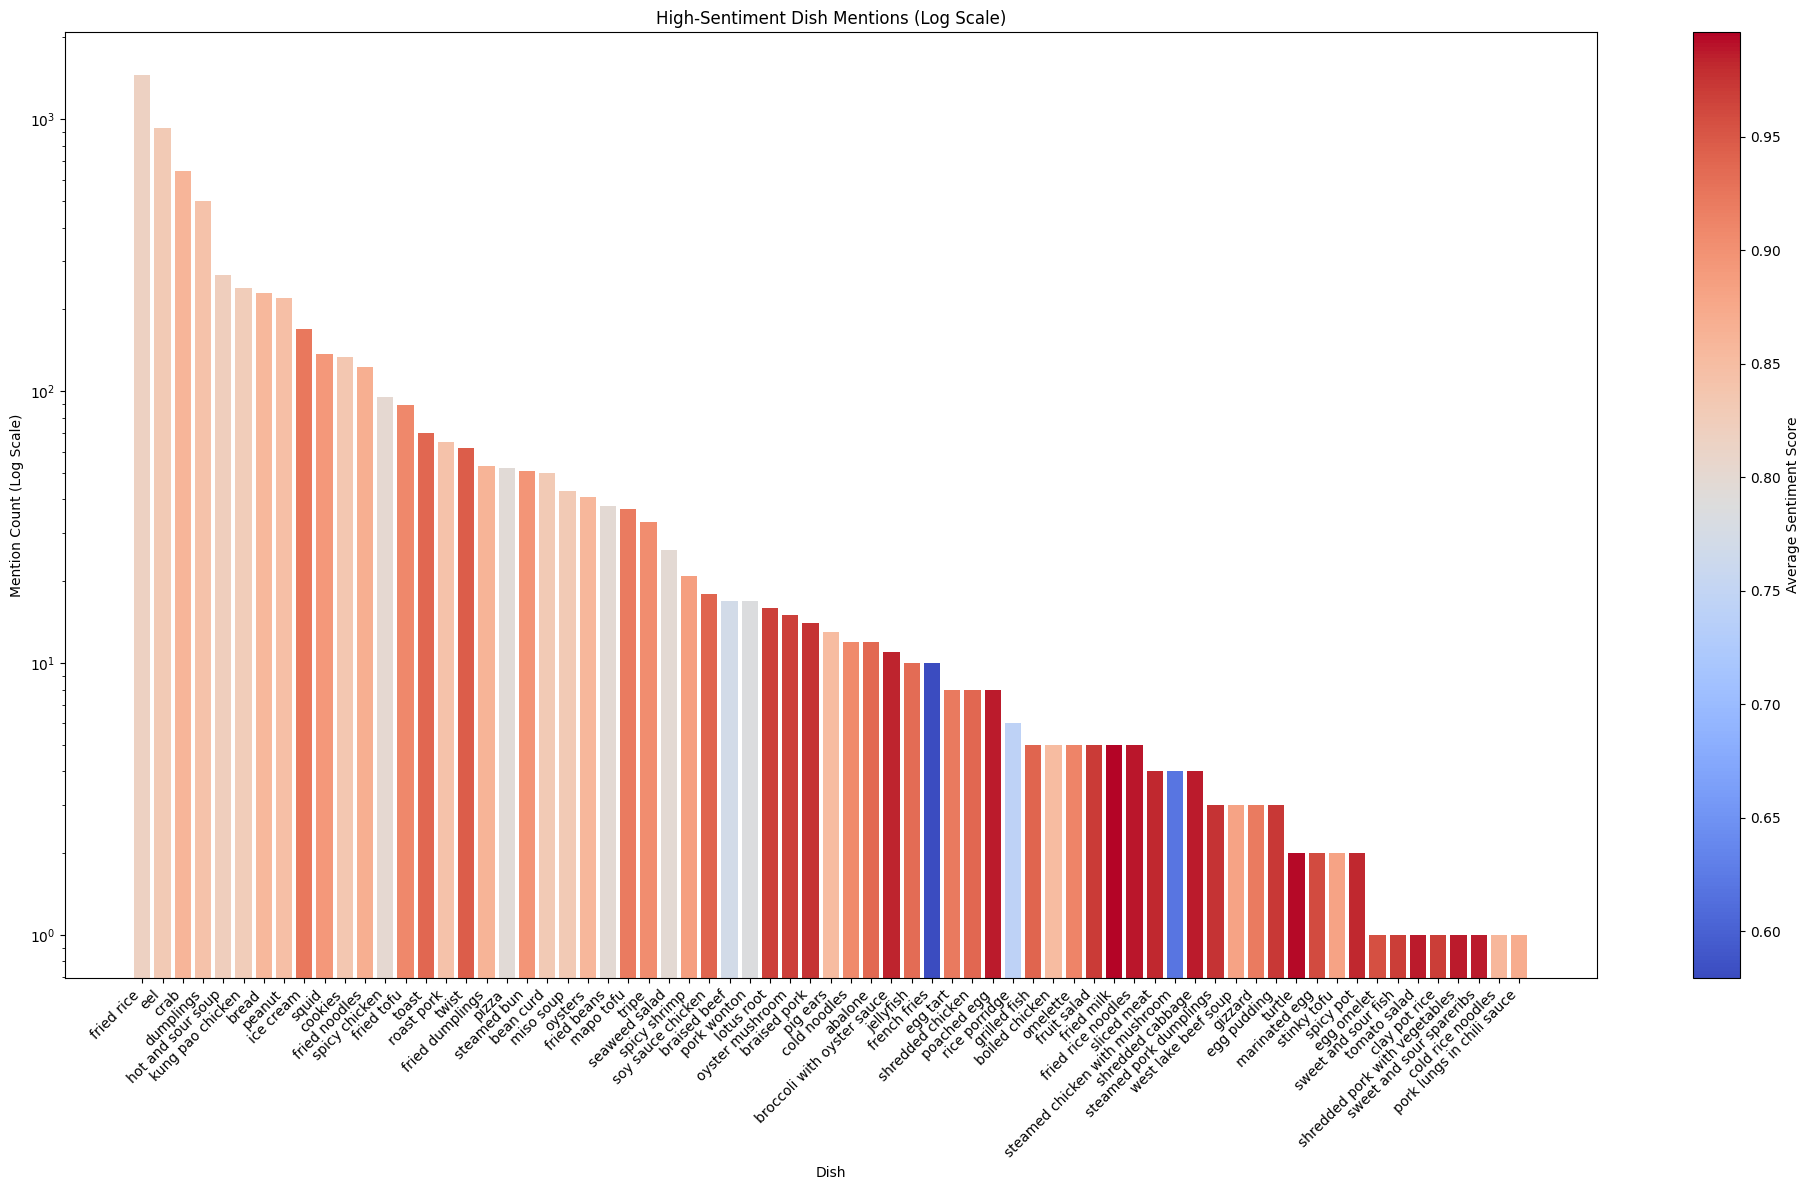

In [50]:
# Recreate the plot with log-scaled y-axis for mention counts

# Filter out dishes with low average sentiment score
# Threshold can be adjusted — here we keep dishes with sentiment > 0.1
filtered_dishes = dish_sentiment_summary[dish_sentiment_summary['avg_sentiment_score'] > 0.5]

# Recreate plot with filtered data
fig, ax = plt.subplots(figsize=(20,12))

# Normalize sentiment scores for coloring
norm = mcolors.Normalize(vmin=filtered_dishes['avg_sentiment_score'].min(),
                         vmax=filtered_dishes['avg_sentiment_score'].max())
cmap = cm.coolwarm
bar_colors = [cmap(norm(score)) for score in filtered_dishes['avg_sentiment_score']]

# Plot bars with log-scaled y-axis
bars = ax.bar(
    filtered_dishes['dish'],
    filtered_dishes['mention_count'],
    color=bar_colors
)

# Set log scale for y-axis
ax.set_yscale('log')

# Fix x-axis labels
ax.set_xticks(range(len(filtered_dishes['dish'])))
ax.set_xticklabels(filtered_dishes['dish'], rotation=45, ha='right')

# Labels and title
ax.set_title("High-Sentiment Dish Mentions (Log Scale)")
ax.set_xlabel("Dish")
ax.set_ylabel("Mention Count (Log Scale)")

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Average Sentiment Score')

plt.tight_layout()
plt.savefig('task4.png')
plt.show()



In [67]:
fried_rice_restaurants = exploded[exploded["mentioned_dishes"] == "fried rice"].copy()


In [76]:
pd.set_option('display.max_colwidth', None)

fried_rice_restaurants[fried_rice_restaurants["name"] == "Waterloo Star"]["text"].to_string()

"999784    Authentic Chinese at a reasonable price. In terms of location, it's about as good as it gets in proximity of UW. The best dish there by far is the Xinjiang Chicken with Rice Noodles. The warm noodles are slathered with a generous helping of spicy chicken chunks and hot peppers and even the regular size is more than enough for dinner and leftovers for the next day. I've also had the fried rice and while it's nothing too special, it's very filling at a very low price (and works great when you're in a pinch, food and money-wise).\\n\\nBe warned however that it is cash only."

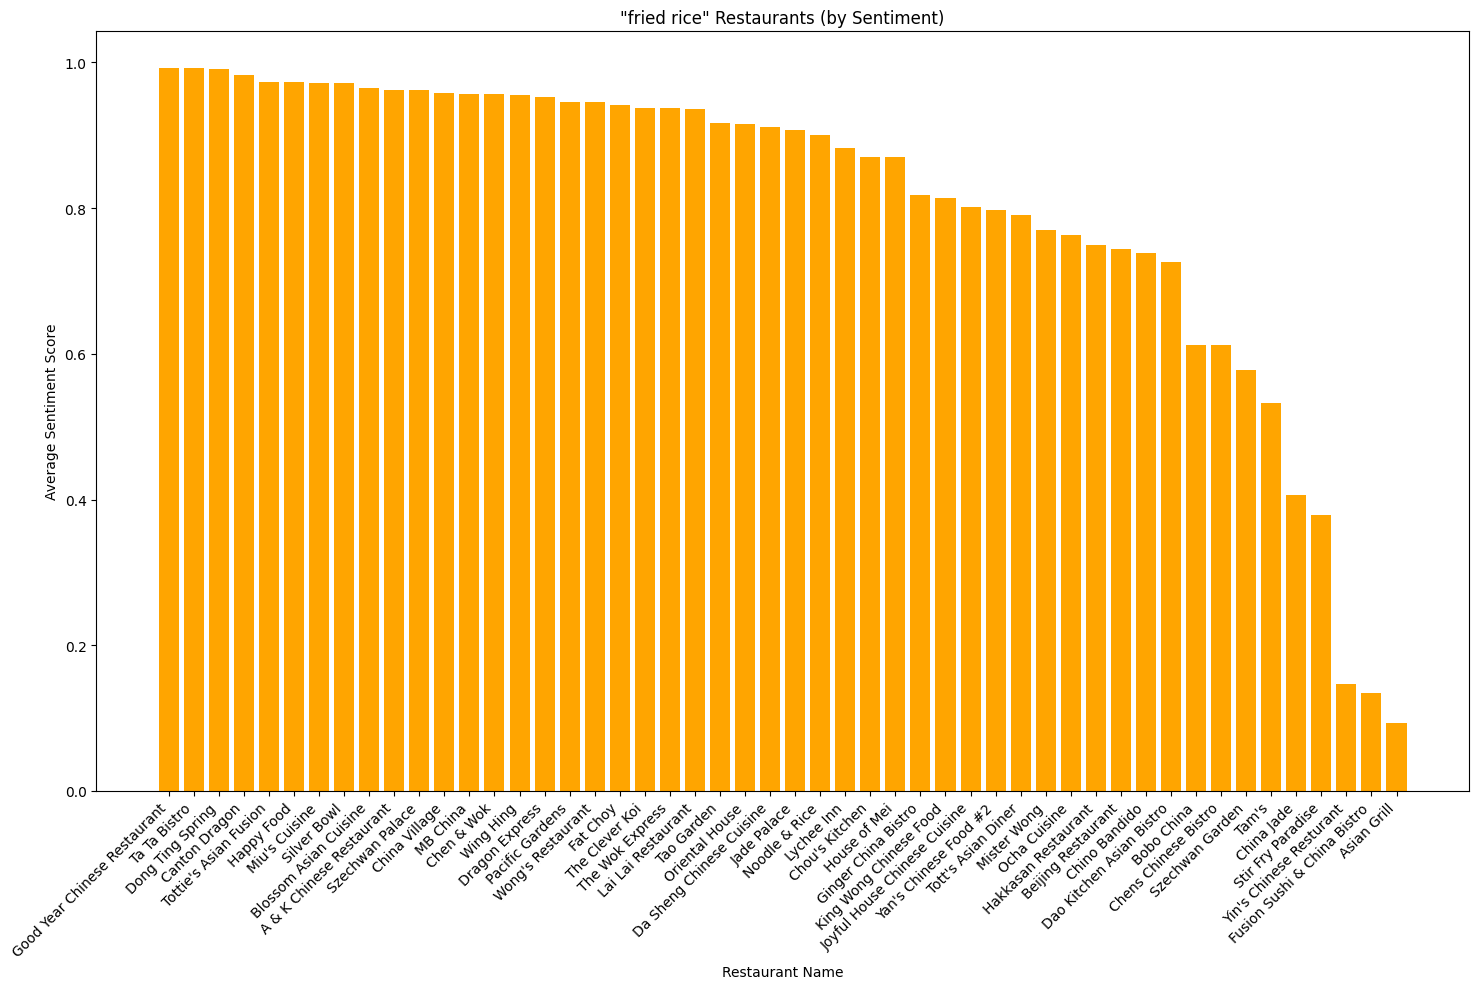

In [88]:
def findBestRestaurantsForDish(dish):
    fried_rice_restaurants = exploded[exploded["mentioned_dishes"] == dish].copy()
    avg_sentiment_by_restaurant = fried_rice_restaurants.groupby('name')['sentiment_score'].mean().reset_index()
    # Count mentions per restaurant for "fried rice"
    mention_counts = fried_rice_restaurants['name'].value_counts().reset_index()
    mention_counts.columns = ['name', 'mention_count']

    # Join with sentiment scores
    avg_sentiment_by_restaurant = fried_rice_restaurants.groupby('name')['sentiment_score'].mean().reset_index()
    restaurant_summary = avg_sentiment_by_restaurant.merge(mention_counts, on='name')

    # Sort the full list of restaurants by mention count descending
    restaurant_summary_full = restaurant_summary.sort_values(by='mention_count', ascending=False).reset_index(drop=True)

    # Get evenly spaced indices over the entire dataset
    evenly_spaced_indices = np.linspace(0, len(restaurant_summary_full) - 1, 50, dtype=int)

    # Select the corresponding 50 restaurants
    evenly_sampled_restaurants = restaurant_summary_full.iloc[evenly_spaced_indices]

    # Sort by average sentiment for display
    evenly_sampled_restaurants = evenly_sampled_restaurants.sort_values(by='sentiment_score', ascending=False)

    # Plot
    plt.figure(figsize=(15, 10))
    plt.bar(evenly_sampled_restaurants['name'], evenly_sampled_restaurants['sentiment_score'], color='orange')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Sentiment Score')
    plt.xlabel('Restaurant Name')
    plt.title('\"{}\" Restaurants (by Sentiment)'.format(dish))
    plt.tight_layout()
    plt.show()
findBestRestaurantsForDish("fried rice")

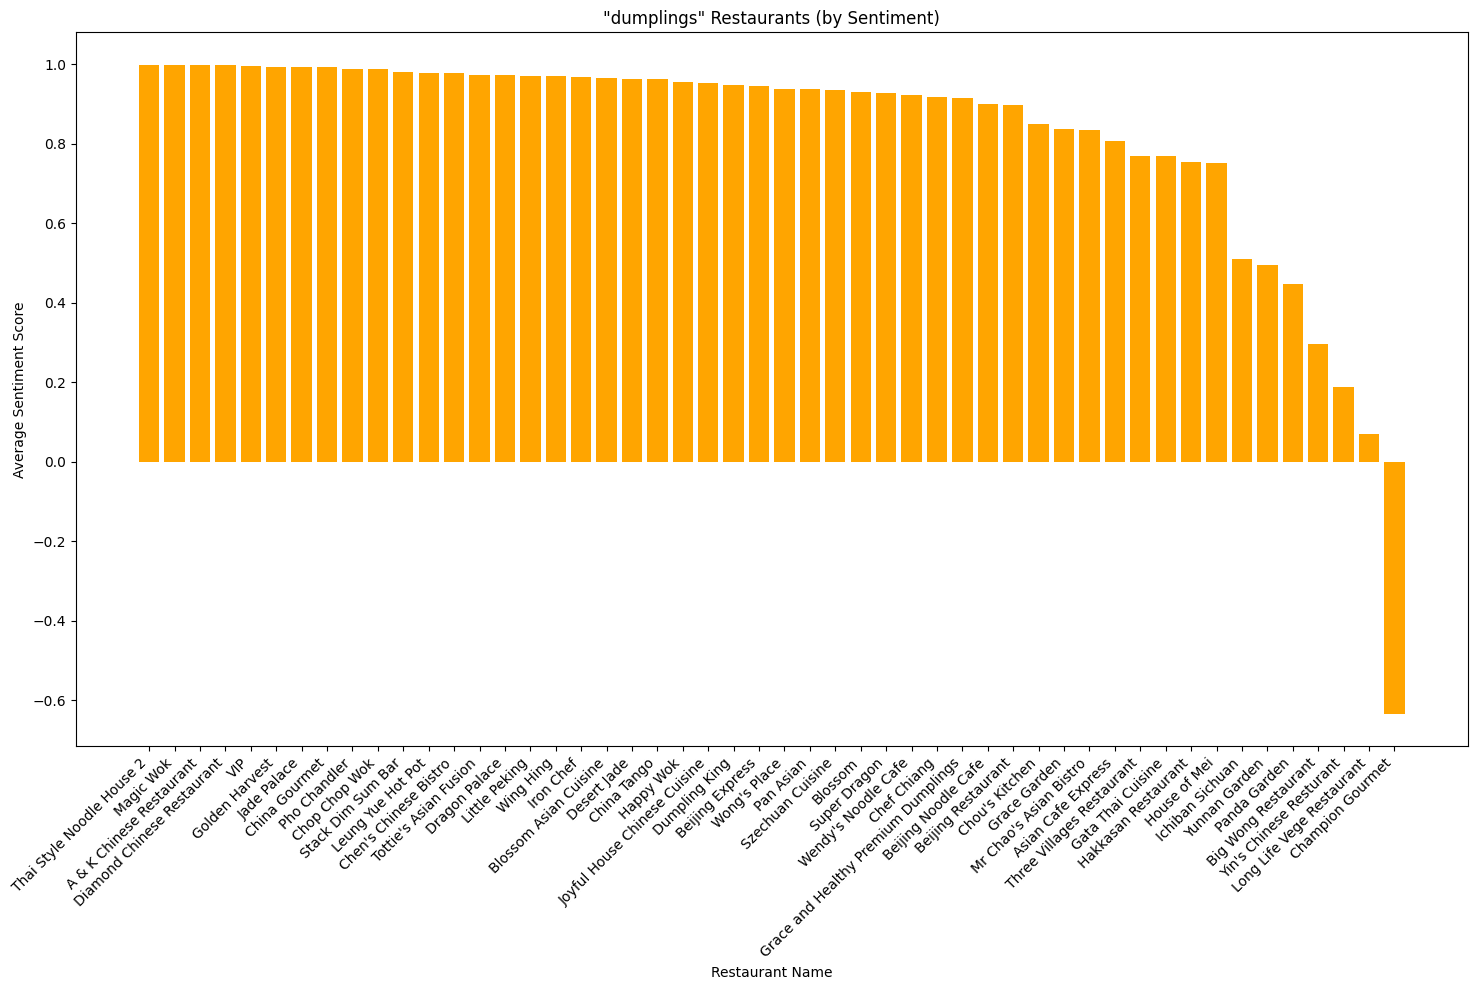

In [89]:
findBestRestaurantsForDish("dumplings")

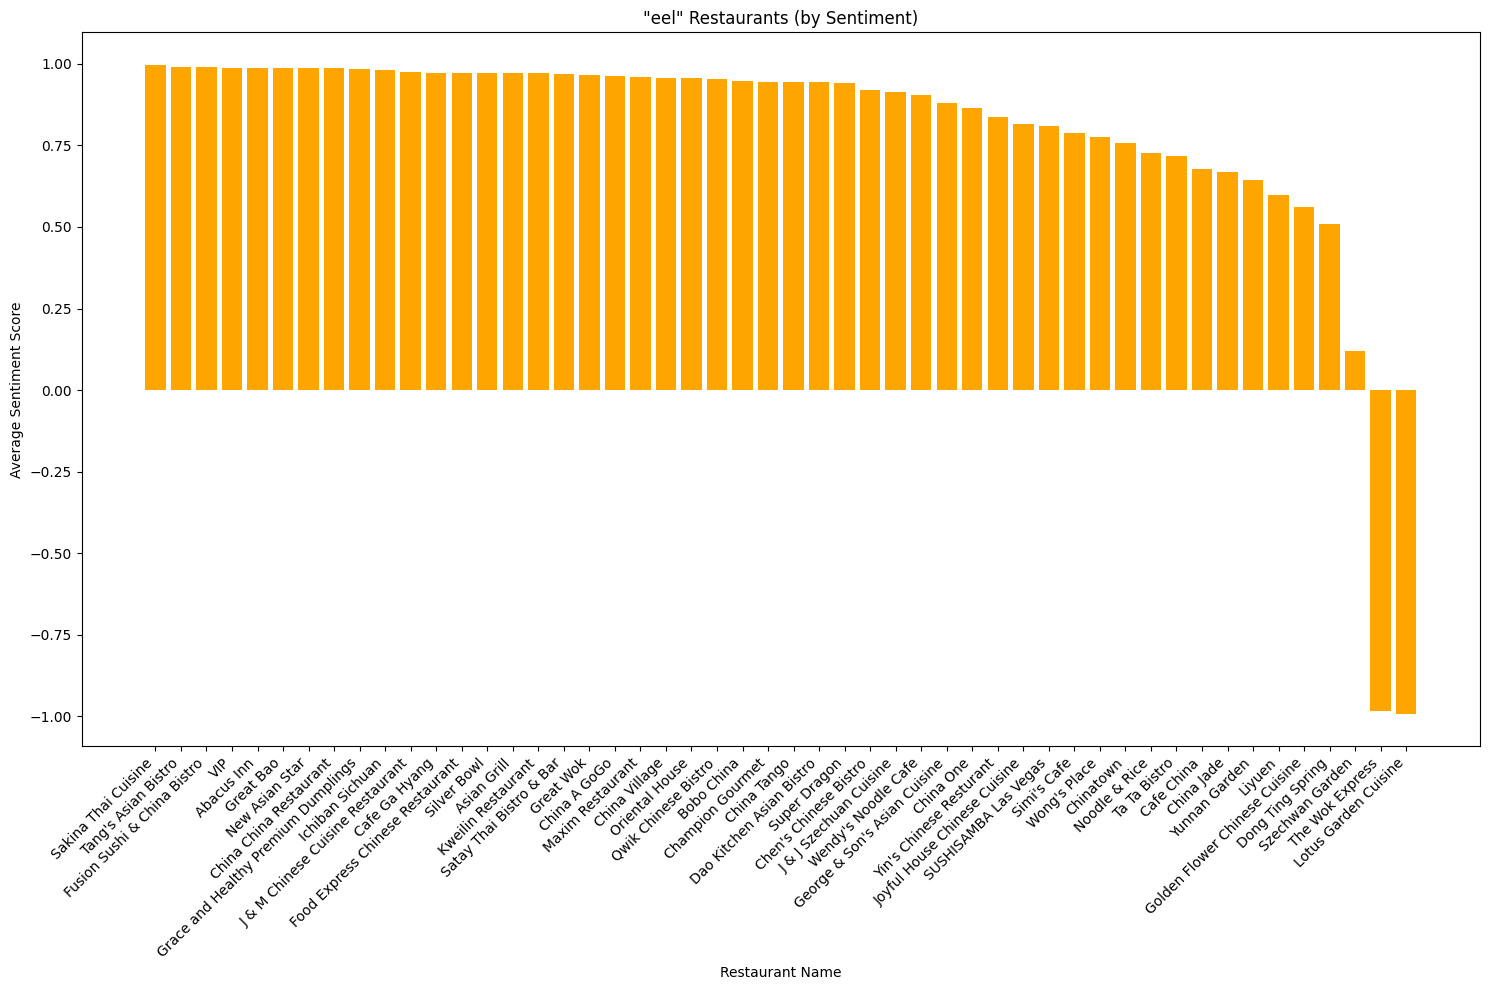

In [90]:
findBestRestaurantsForDish("eel")

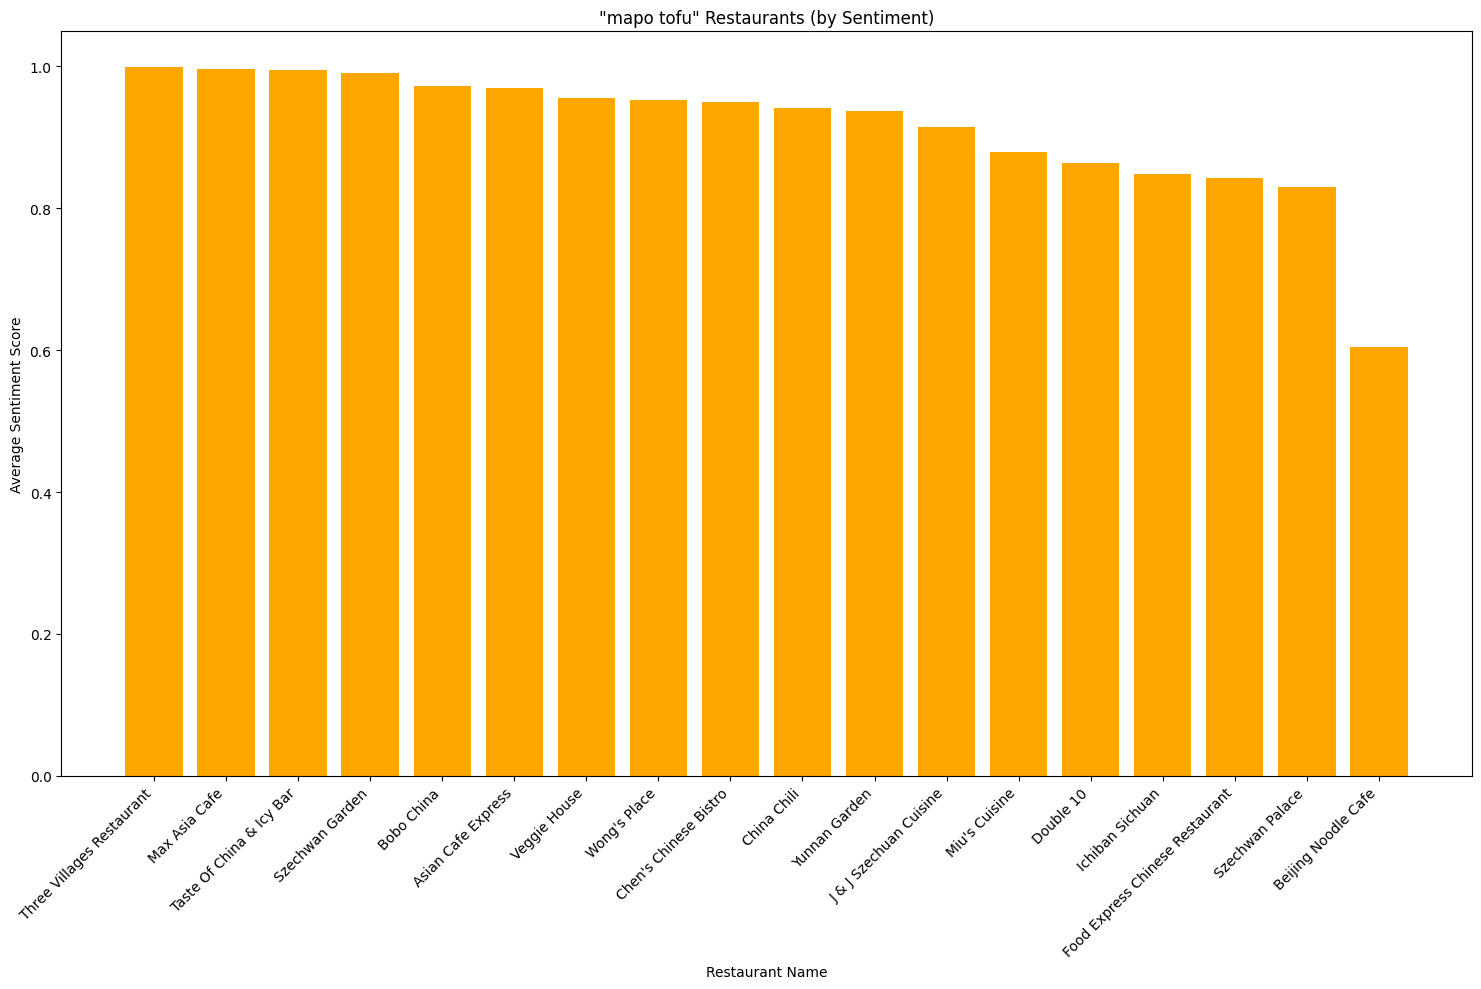

In [91]:
findBestRestaurantsForDish("mapo tofu")